$ \langle v\rangle = \int_{0}^{\infty} p(R)v(R)dR = \frac{4\pi}{3} \int_{0}^{\infty} p(R)R^3 dR $

$ \langle N \rangle= \frac{V_{tot}}{\langle v\rangle} $

$ \phi = \frac{\langle N\rangle -N_{real}}{\langle N\rangle} $

$ \xi \sim \langle h\rangle ^{1/z} $

R_median= 7 ; (normal pdf)  mu= 1.946 ; sigma= 0.33


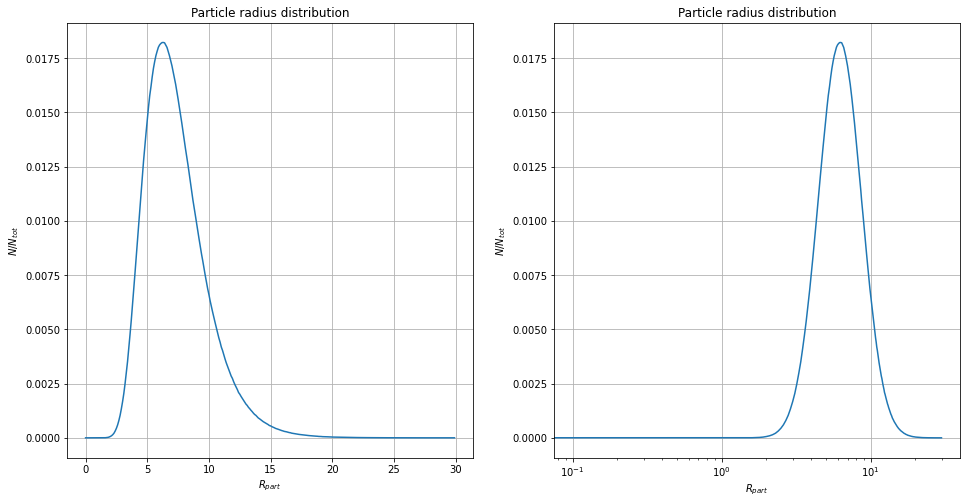

In [1]:
import numpy as np
import matplotlib.pyplot as plt

R_median=7
sigma=0.33
mu=np.log(R_median)


r,pdf=np.loadtxt('scaling_mpi1kk/r_hist.dat')
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(r,pdf)
plt.title('Particle radius distribution')
plt.xlabel(r'$R_{part}$')
plt.ylabel(r'$N/ N_{tot}$')
plt.grid()
plt.subplot(122)
plt.plot(r,pdf)
plt.title('Particle radius distribution')
plt.xscale('log')
plt.xlabel(r'$R_{part}$')
plt.ylabel(r'$N/ N_{tot}$')
plt.grid()

print('R_median=', R_median, '; (normal pdf)  mu=', round(mu,3), '; sigma=', sigma)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def plotpar_fromfile(filename, xlab, ylab, xscale='linear', yscale='linear', a=0, b=0, xfile='', return_par=False):
    est, Ntrue, err= np.loadtxt(filename)
    if xfile!='': Ntrue,N,newx_err=np.loadtxt(xfile) #metto il parametro in Ntrue
    
    out=open(filename)
    line1=out.readline()
    line2=out.readline()
    param=np.fromstring(line1[2:], sep=' ')
    name=line2[2:].split()
    out.close()
    
    print('last value:', round(est[-1],1))
    plt.figure(figsize=(8,6))
    if xfile=='': plt.errorbar(Ntrue, est, yerr=err)
    else: plt.errorbar(Ntrue, est, yerr=err, xerr=newx_err)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.title(name[0]+'='+str(round(param[0], 2))+', '+name[1]+'='+str(round(param[1], 2)))
    if a<b:
        passedA=False
        for i in range(len(Ntrue)):
            if Ntrue[i]>a and not(passedA):
                a=i
                passedA=True
                
            if Ntrue[i]>b: break
            else: b_ind=i
        
        x=Ntrue[a:b_ind].reshape(-1,1)
        y=  est[a:b_ind].reshape(-1,1)
        if xscale=='log': x_reg=np.log10(x)
        else: x_reg=x
        
        if yscale=='log': y_reg=np.log10(y)
        else: y_reg=y
            
        model  = LinearRegression().fit(x_reg,y_reg)
        
        if yscale=='log': plt.plot(x,10 ** model.predict(x_reg), color='red', label='fit', lw=3)
        else: plt.plot(x,model.predict(x_reg), color='green', lw=3)
        plt.legend()
        print('coefficient:',round(model.coef_[0][0], 3))
        print('sqrt(mse):', round(np.sqrt(mean_squared_error(y_reg, model.predict(x_reg))), 3) )
    plt.show()
    if return_par: return model.coef_[0][0], mean_squared_error(y_reg, model.predict(x_reg))

last value: 2.1


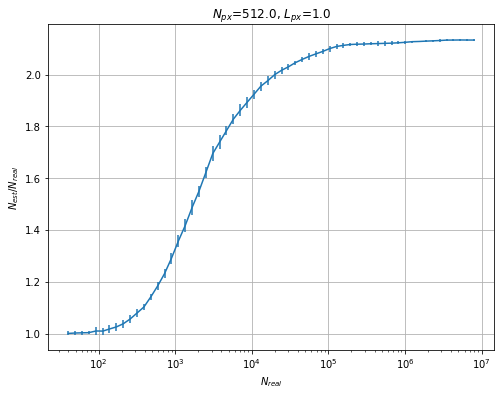

In [23]:
plotpar_fromfile('scaling_1d_512/V_relvsN.dat', r'$N_{real}$', r'$N_{est} / N_{real}$', xscale='log', yscale='linear')#, a=80,b=5000)

last value: 33325.4


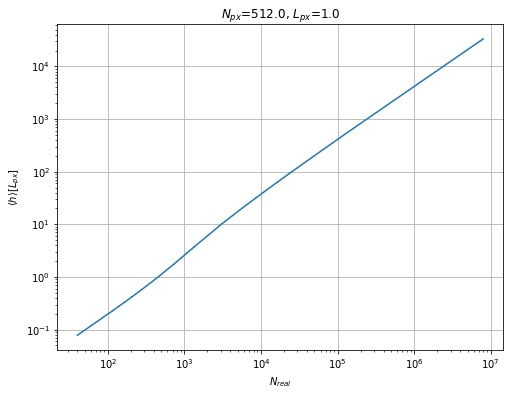

last value: 33350.1


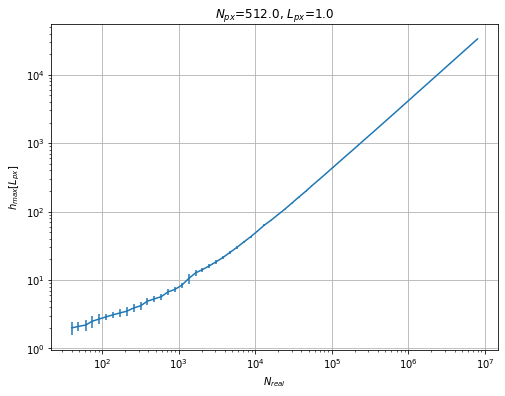

In [24]:
plotpar_fromfile('scaling_1d_512/hvsN.dat', r'$N_{real}$', r'$ \langle h\rangle [L_{px}]$', xscale='log', yscale='log')#, a=100, b=10000)
plotpar_fromfile('scaling_1d_512/maxhvsN.dat', r'$N_{real}$', r'$h_{max} [L_{px}]$', xscale='log', yscale='log')#, a=10,b=1000)

last value: 10.6
coefficient: 0.28
sqrt(mse): 0.016


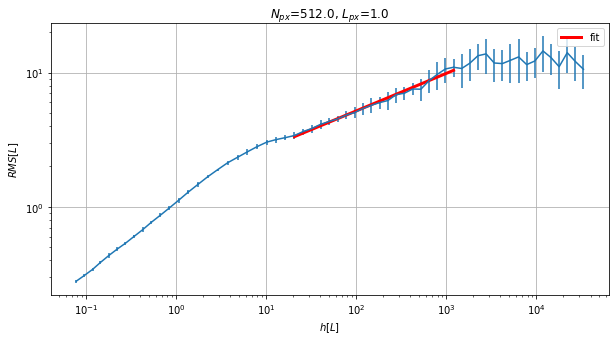

In [58]:
beta, beta_err= plotpar_fromfile('scaling_1d_512_newcorr/rmsvsN.dat', r'$h [L]$', r'$RMS [L]$', xscale='log', yscale='log', a=20,b=1500, xfile='scaling_1d_512_newcorr/hvsN.dat', return_par=True)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

def G_gauss_prof(lLw, alfa):
    l_xy,L,w=lLw
    return 2*w**2 *( 1-np.exp(- (l_xy/L)**(2*alfa)) )

def G_red_gauss_prof(lL, alfa):
    l_xy,L=lL
    return 1-np.exp(- (l_xy/L)**(2*alfa))

def C_red(l, eps): return np.exp(-l/eps)

def plotcorr_fromfile(filename, Nline, xscale='linear', yscale='linear', a=0, b=0, L=-1, plotting=True, fit=False, upx=0, lwy=0, upy=0):
    ind=filename.find('/')
    h_inst, Ntrue=np.loadtxt(filename[:ind+1]+'hvsN.dat', max_rows=2)
    rms = np.loadtxt(filename[:ind+1]+'rmsvsN.dat', max_rows=1)
    x=np.arange(int(filename[11:14]))
    
    out=open(filename)
    for i in range(Nline-1): out.readline()
    line=out.readline()
    y=np.fromstring(line, sep=' ')
    out.close()
    if filename[ind+1]=='C': y/=rms[Nline-1]**2
    if filename[ind+1]=='G':
#        x/=L
        y/=2*rms[Nline-1]**2
    
    out=open(filename[:ind+2]+'2.dat')
    for i in range(Nline-1): out.readline()
    line=out.readline()
    err=np.sqrt(np.fromstring(line, sep=' '))
    out.close()
    
    if plotting:
        plt.figure(figsize=(15,5))
#        plt.errorbar(x, y, yerr=err)
        plt.plot(x,y, lw=2, label=filename[ind+1])
        if upx!=0: plt.xlim(0.04,upx)
#        plt.xlim(0,upx)
        if upy!=0: plt.ylim(lwy,upy)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.xlabel(r'$r [L]$')
        plt.ylabel(filename[ind+1]+'$/2w^2 $')
        plt.grid()
        if filename[ind+1]=='C': plt.title('height correlation function: Npx=1024,  N='+str(Ntrue[Nline-1])+', h='+str(round(h_inst[Nline-1], 2))+' Lpx, RMS='+str(round(rms[Nline-1], 2))+' Lpx')
        if filename[ind+1]=='G': plt.title('height-height correlation function: Npx=1024,  N='+str(Ntrue[Nline-1])+', RMS='+str(round(rms[Nline-1], 2))+' Lpx')
    
    if L>0 and filename[ind+1]=='G' and fit:
        opt,cov= curve_fit(G_red_gauss_prof, (x, np.ones(len(x))*L), y, bounds=(0,2))
#        print(opt, cov[0])
        if plotting: plt.plot(x,G_red_gauss_prof((x, np.ones(len(x))*L),opt[0]), ls='dashed')

    if filename[ind+1]=='C' and fit:
        opt,cov= curve_fit(C_red_, x, y)
#        print(opt, cov[0])
        if plotting: plt.plot(x,C_red(x,opt[0]), ls='dashed', label='fit')
    
    if a<b and not(fit):
        passedA=False
        for i in range(len(x)):
            if x[i]>a and not(passedA):
                a=i
                passedA=True
                
            if x[i]>b: break
            else: b_ind=i
        
        x=x[a:b_ind].reshape(-1,1)
        y=  y[a:b_ind].reshape(-1,1)
        if xscale=='log': x_reg=np.log10(x)
        else: x_reg=x
        
        if yscale=='log': y_reg=np.log10(y)
        else: y_reg=y
            
        model  = LinearRegression().fit(x_reg,y_reg)
        
        if plotting:
            if yscale=='log': plt.plot(x,10 ** model.predict(x_reg), color='red', ls='dashed', label='fit')
            else: plt.plot(x,model.predict(x_reg), color='red', ls='dashed')
#            print('coefficient:',model.coef_[0][0])
#            print('mean squared error:', mean_squared_error(y_reg, model.predict(x_reg)) )
            plt.legend()
        if filename[ind+1]=='C': return - model.coef_[0][0]**-1 *np.log10(np.exp(1)), np.sqrt(mean_squared_error(y_reg, model.predict(x_reg))) *np.log10(np.exp(1))/ model.coef_[0][0]
        if filename[ind+1]=='G': return model.coef_[0][0], np.sqrt(mean_squared_error(y_reg, model.predict(x_reg)))
    if L>0 and filename[ind+1]=='G' and fit: return opt[0], cov[0][0]
    if filename[ind+1]=='C' and fit: return opt[0], cov[0][0]

correl length: 20.699053044676983
alpha (fit): 0.5615427254080211
alpha (lin): 0.5181882271485092


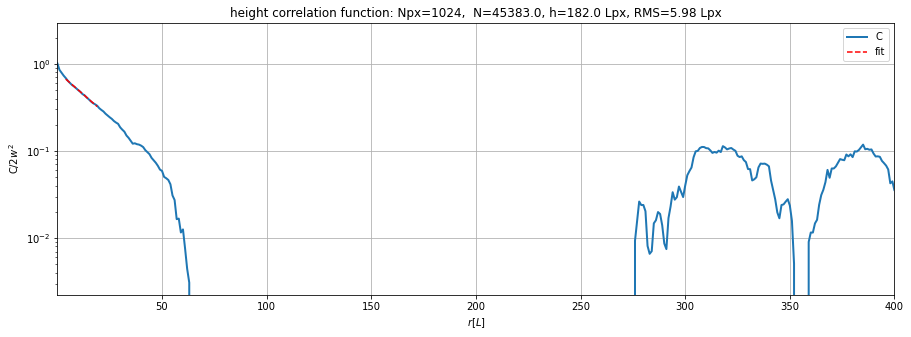

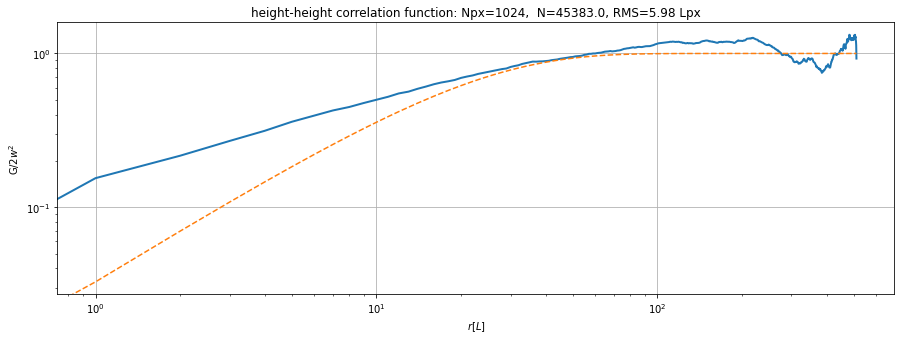

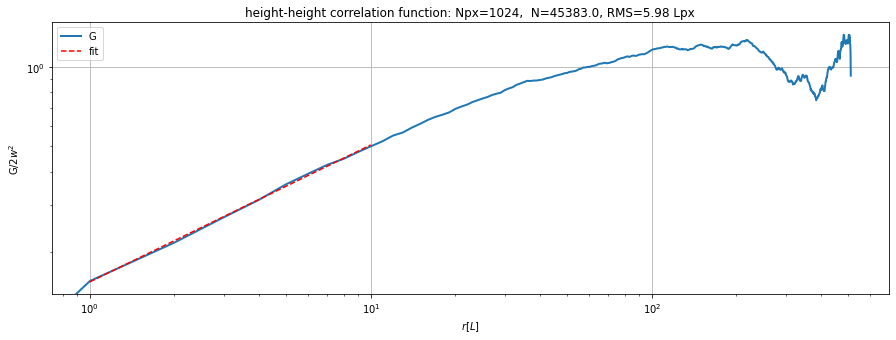

In [8]:
lll=35
lp,e=plotcorr_fromfile('scaling_1d_512_newcorr/C.dat', lll, xscale='linear', yscale='log', a=3,b=20, upx=400)
print('correl length:', lp)
#pa,e=plotcorr_fromfile('scaling_mpi1kk/C.dat', lll, xscale='linear', yscale='linear', fit=True)
#print('correl length:', pa)
p,e=plotcorr_fromfile('scaling_1d_512_newcorr/G.dat', lll, xscale='log', yscale='log', a=0,b=11, L=lp, fit=True)
print('alpha (fit):', p)
p,e=plotcorr_fromfile('scaling_1d_512_newcorr/G.dat', lll, xscale='log', yscale='log', a=0,b=11, L=lp)
print('alpha (lin):', p)

slope: 0.713
sqrt(mse): 0.032


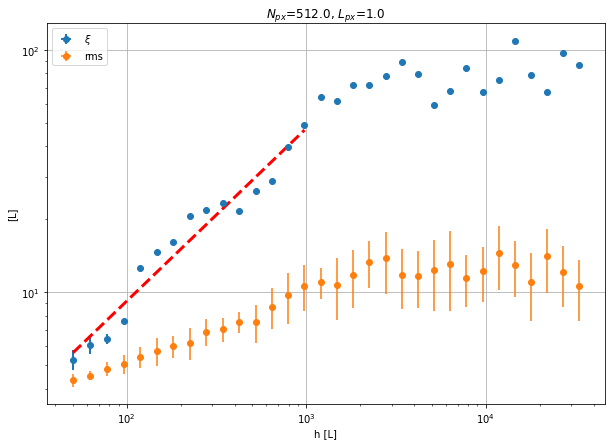

In [3]:
Lcorr=np.array([])
L_err=np.array([])

Nlin=np.arange(28,60)
aa=3
bb=20
for i in Nlin:
    p,e=plotcorr_fromfile('scaling_1d_512_newcorr/C.dat', i, xscale='linear', yscale='log', a=aa,b=bb, plotting=False)
    Lcorr=np.append(Lcorr, p)
    L_err=np.append(L_err, e)

h, Ntrue, h_err=np.loadtxt('scaling_1d_512_newcorr/hvsN.dat')
rms, Ntrue, rms_err=np.loadtxt('scaling_1d_512_newcorr/rmsvsN.dat')

out=open('scaling_1d_512_newcorr/rmsvsN.dat')
line1=out.readline()
line2=out.readline()
param=np.fromstring(line1[2:], sep=' ')
name=line2[2:].split()
out.close()

plt.figure(figsize=(10,7))
plt.errorbar(h[Nlin], Lcorr, yerr=L_err, xerr=h_err[Nlin], label=r'$ \xi $', lw=2, fmt='o')
plt.errorbar(h[Nlin], rms[Nlin], yerr=rms_err[Nlin], xerr=h_err[Nlin], label='rms', fmt='o')
plt.title(name[0]+'='+str(round(param[0], 2))+', '+name[1]+'='+str(round(param[1], 2)))
plt.xlabel('h [L]')
plt.ylabel('[L]')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

passedA=False
a=50
b=1400
for i in range(len(Nlin)):
    if h[Nlin][i]>a and not(passedA):
        a=i
        passedA=True
                
    if h[Nlin][i]>b: break
    else: b_ind=i
        
xx=h[Nlin][a:b_ind].reshape(-1,1)
yy=  Lcorr[a:b_ind].reshape(-1,1)
x_reg=np.log10(xx)
y_reg=np.log10(yy)

model  = LinearRegression().fit(x_reg,y_reg)
plt.plot(xx,10 ** model.predict(x_reg), color='red', ls='dashed', lw=3)
print('slope:',round(model.coef_[0][0], 3))
print('sqrt(mse):', round(np.sqrt(mean_squared_error(y_reg, model.predict(x_reg)))/2, 3))
plt.show()

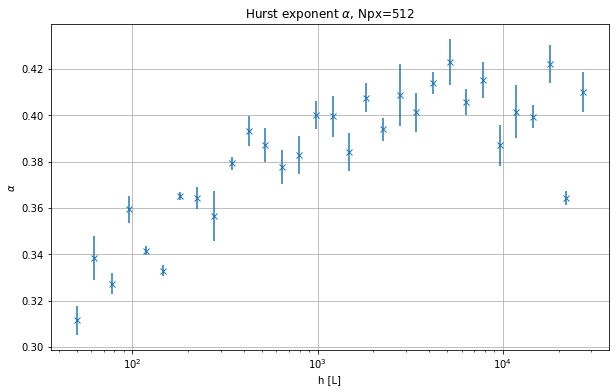

av. alfa: 0.38


In [16]:
alfa =np.array([])
alfa_err=np.array([])

Nlin=np.arange(28,59)
for i in range(len(Nlin)):
    p,e=plotcorr_fromfile('scaling_1d_512_newcorr/G.dat', Nlin[i], xscale='log', yscale='log', a=0,b=10, L=Lcorr[i], plotting=False)
    alfa=np.append(alfa, p)
    alfa_err=np.append(alfa_err, e)

plt.figure(figsize=(10,6))
plt.errorbar(h[Nlin], 0.7*alfa, yerr=alfa_err, xerr=h_err[Nlin], fmt='x')
plt.xscale('log')
#plt.yscale('log')
plt.title(r'Hurst exponent $\alpha $, Npx=512')
plt.ylabel(r'$\alpha $')
plt.xlabel('h [L]')
plt.grid()
plt.show()

print('av. alfa:', round(np.mean(0.7*alfa), 2))
#np.savetxt('alfa1024.dat', (h[Nlin], alfa, alfa_err, h_err[Nlin]))

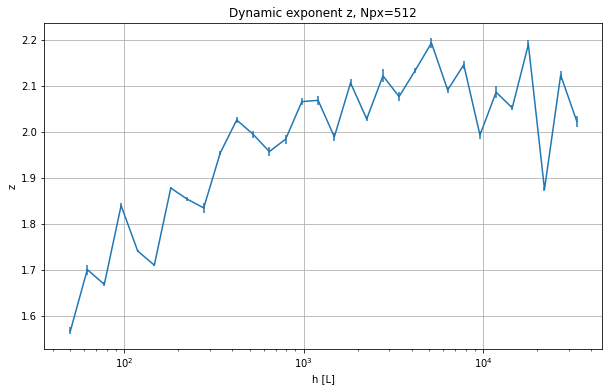

zeta av: 1.9709572785891083


In [59]:
plt.figure(figsize=(10,6))
plt.errorbar(h[Nlin], alfa/beta, yerr=alfa_err, xerr=h_err[Nlin])
plt.xscale('log')
#plt.yscale('log')
plt.title('Dynamic exponent z, Npx=512')
plt.ylabel('z')
plt.xlabel('h [L]')
plt.grid()
plt.show()

print('zeta av:', np.mean(alfa/beta))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

def plotcorr_fromfil(filename, Nline, xscale='linear', yscale='linear', a=0, b=0, L=-1, plotting=True, fit=False, upx=0, lwy=0, upy=0):
    ind=filename.find('/')
    h_inst, Ntrue=np.loadtxt(filename[:ind+1]+'hvsN.dat', max_rows=2)
    rms = 36.98
    x=np.arange(512)
    
    out=open(filename)
    for i in range(Nline-1): out.readline()
    line=out.readline()
    y=np.fromstring(line, sep=' ')
    out.close()
    if filename[ind+1]=='C': y/=y[0]
#    if filename[ind+1]=='G': y/=2*rms[Nline-1]**2
    
    out=open(filename[:ind+2]+'2.dat')
    for i in range(Nline-1): out.readline()
    line=out.readline()
    err=np.sqrt(np.fromstring(line, sep=' '))/y[0]
    out.close()
    
    if plotting:
        plt.figure(figsize=(15,5))
#        plt.errorbar(x, y, yerr=err)
        plt.plot(x,y, lw=2, label=r'$ C $')
        if upx!=0: plt.xlim(1,upx)
        if upy!=0: plt.ylim(lwy,upy)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.xlabel(r'$r [L]$')
        plt.ylabel(filename[ind+1]+r'$/w^2 $')
        plt.grid()
        if filename[ind+1]=='C': plt.title('height correlation function, Npx=1800,  N='+str(Ntrue[Nline-1])+',  h='+str(round(h_inst[Nline-1], 2))+' [L], RMS='+str(round(rms, 2))+' [L]')
        if filename[ind+1]=='G': plt.title('height-height correlation function, N='+str(Ntrue[Nline-1])+', RMS='+str(round(rms[Nline-1], 2))+' Lpx')
    
    if L>0 and filename[ind+1]=='G' and fit:
        opt,cov= curve_fit(G_red_gauss_prof, (x, np.ones(len(x))*L), y, bounds=(0,2))
#        print(opt, cov[0])
        if plotting: plt.plot(x,G_red_gauss_prof((x, np.ones(len(x))*L),opt[0]), ls='dashed')

    if filename[ind+1]=='C' and fit:
        opt,cov= curve_fit(C_red, x, y)
        #print(opt, cov[0])
        if plotting: plt.plot(x,C_red(x,opt[0]), ls='dashed', label='fit')
    plt.legend()
    
    if a<b and not(fit):
        passedA=False
        for i in range(len(x)):
            if x[i]>a and not(passedA):
                a=i
                passedA=True
                
            if x[i]>b: break
            else: b_ind=i
        
        x=x[a:b_ind].reshape(-1,1)
        y=  y[a:b_ind].reshape(-1,1)
        if xscale=='log': x_reg=np.log10(x)
        else: x_reg=x
        
        if yscale=='log': y_reg=np.log10(y)
        else: y_reg=y
            
        model  = LinearRegression().fit(x_reg,y_reg)
        
        if plotting:
            if yscale=='log': plt.plot(x,10 ** model.predict(x_reg), color='red', ls='dashed')
            else: plt.plot(x,model.predict(x_reg), color='red', ls='dashed')
#            print('coefficient:',model.coef_[0][0])
#            print('mean squared error:', mean_squared_error(y_reg, model.predict(x_reg)) )
#    plt.show()
        if filename[ind+1]=='C': return - model.coef_[0][0]**-1 *np.log10(np.exp(1)), np.sqrt(mean_squared_error(y_reg, model.predict(x_reg))) *np.log10(np.exp(1))/ model.coef_[0][0]
        if filename[ind+1]=='G': return model.coef_[0][0]/2, np.sqrt(mean_squared_error(y_reg, model.predict(x_reg)))/2
    if L>0 and filename[ind+1]=='G': return opt[0], cov[0][0]
    if filename[ind+1]=='C' and fit: return opt[0], cov[0][0]

(22.518052514720925, 4.452477310549194)

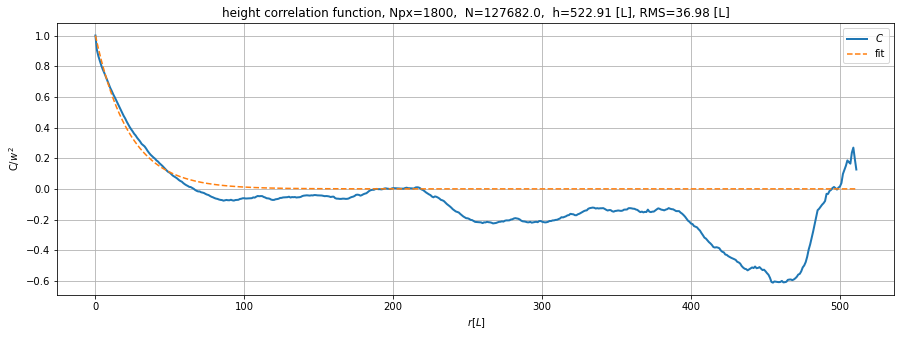

In [12]:
lll=40
#p,e=
plotcorr_fromfil('scaling_1d_512_newcorr/C.dat', lll, xscale='linear', yscale='linear', fit=True)

(6.742942577566754, -1.181762315735443)

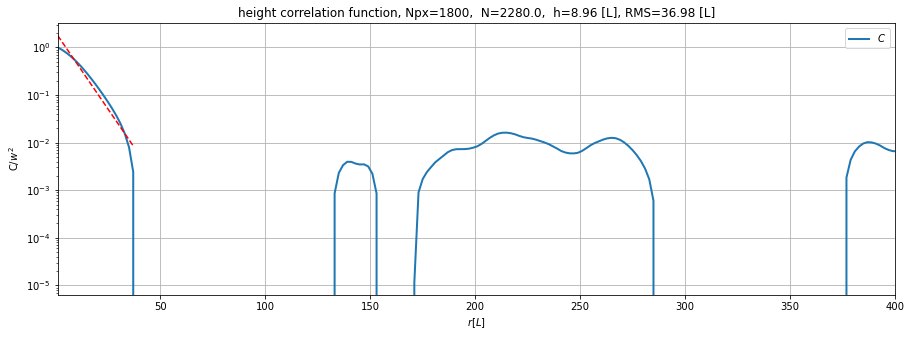

In [26]:
lll=30
#p,e=
plotcorr_fromfil('newcorr/C.dat', lll, xscale='linear', yscale='log', a=0, b=40, upx=400)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

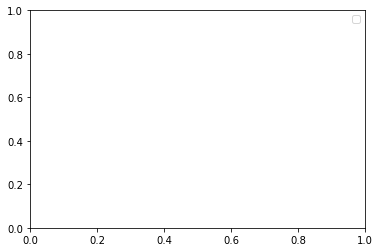

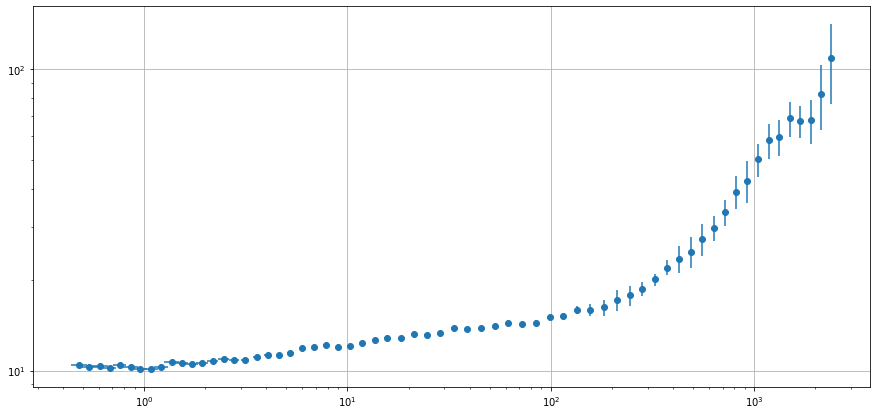

In [21]:
Lcorr=np.array([])
L_err=np.array([])

Nlin=np.arange(5,70)
for i in Nlin:
    p,e=plotcorr_fromfil('newcorr/C.dat', i, xscale='linear', yscale='linear', fit=True, plotting=False)
    Lcorr=np.append(Lcorr, p)
    L_err=np.append(L_err, e)

h, Ntrue, h_err=np.loadtxt('newcorr/hvsN.dat')
plt.figure(figsize=(15,7))
plt.errorbar(h[Nlin], Lcorr, yerr=L_err, xerr=h_err[Nlin], fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

slope (1/z): 0.5217


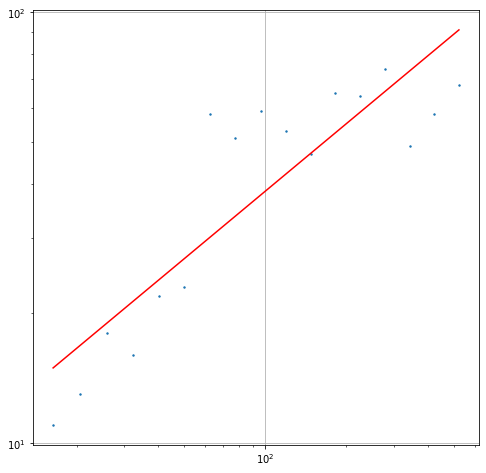

In [71]:
from scipy import stats

Lcorr=np.array([])
L_err=np.array([])

Nlin=np.arange(23,40)

out=open('scaling_1d_512_newcorr/C.dat')
for i in range(Nlin[0]): out.readline()
for i in range(Nlin[-1]+1-Nlin[0]):
    line=out.readline()
    y=np.fromstring(line, sep=' ')

    for j in range(len(y)):
        #print(y[j])
        if y[j]<0:
            #print(i)
            Lcorr=np.append(Lcorr, j+1)
            break

out.close()

h=np.loadtxt('scaling_1d_512_newcorr/hvsN.dat', max_rows=1)
plt.figure(figsize=(8,8))
plt.scatter(h[Nlin], Lcorr, s=2)
res= stats.linregress(np.log10(h[Nlin]), np.log10(Lcorr))
plt.plot(h[Nlin], 10**res.intercept * h[Nlin]**res.slope, 'r', label='fitted line')
print('slope (1/z):', round(res.slope,4))
plt.xscale('log')
plt.yscale('log')
plt.grid()